# Lesson 8 - Time Series Analysis 
## Author - Salinee Kingbaisomboon
### UW NetID: 1950831

## Instructions

Using the California dairy production dataset, perform time series analysis on the data for one of Cottage Cheese Production, Milk Production, or Ice Cream Production (your choice) to answer the following questions:

1. Is this time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

Then forecast production for 12 months and report both numeric values and plot the confidence intervals.

1. Are the confidence intervals reasonably small compared to the forecast means?
2. How do the confidence intervals behave as time moves to the future?


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [154]:
# Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"

In [155]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import zscore
import sklearn.linear_model as lm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as splt
import statsmodels.tsa.seasonal as sts

import warnings

warnings.filterwarnings("ignore") # To suppress warning

%matplotlib inline

In [156]:
# Read the .csv file with the pandas read_csv method
df = pd.read_csv(fileName)

# View the first 5 rows of this dataframe (Start from Jan 1995)
df.head()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
0,1995,Jan,4.370,51.595,2.112,0.9803,1,1,1
1,1995,Feb,3.695,56.086,1.932,0.8924,2,4,8
2,1995,Mar,4.538,68.453,2.162,0.8924,3,9,27
3,1995,Apr,4.280,65.722,2.130,0.8967,4,16,64
4,1995,May,4.470,73.730,2.227,0.8967,5,25,125


In [157]:
# View the last 5 rows of this dataframe (End at Dec 2013)
df.tail()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
223,2013,Aug,2.169,78.382,3.400,1.6273,224,50176,11239424
224,2013,Sep,2.193,74.871,3.197,1.5519,225,50625,11390625
225,2013,Oct,2.284,70.011,3.338,1.5566,226,51076,11543176
226,2013,Nov,1.865,61.394,3.275,1.7537,227,51529,11697083
227,2013,Dec,2.345,53.653,3.473,1.6747,228,51984,11852352


In [158]:
# Adds a new set of index values to the Pandas series from Jan 1, 1995 to Dec 31, 2013 (Frequenly = Month)
df.index = pd.date_range(start = '1-1-1995', end = '12-31-2013', freq = 'M')
# View the first 5 rows of this dataframe
df.head()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
1995-01-31,1995,Jan,4.370,51.595,2.112,0.9803,1,1,1
1995-02-28,1995,Feb,3.695,56.086,1.932,0.8924,2,4,8
1995-03-31,1995,Mar,4.538,68.453,2.162,0.8924,3,9,27
1995-04-30,1995,Apr,4.280,65.722,2.130,0.8967,4,16,64
1995-05-31,1995,May,4.470,73.730,2.227,0.8967,5,25,125


In [159]:
# View the last 5 rows of this dataframe
df.tail()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
2013-08-31,2013,Aug,2.169,78.382,3.400,1.6273,224,50176,11239424
2013-09-30,2013,Sep,2.193,74.871,3.197,1.5519,225,50625,11390625
2013-10-31,2013,Oct,2.284,70.011,3.338,1.5566,226,51076,11543176
2013-11-30,2013,Nov,1.865,61.394,3.275,1.7537,227,51529,11697083
2013-12-31,2013,Dec,2.345,53.653,3.473,1.6747,228,51984,11852352


# Declare Functions used in this assignment

In [160]:
# Function to plot distribution of the time series values
def dist_ts(ts, lab = '', bins = 40):
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)

In [161]:
# Function to decomposition of Time Series with monthly seasonal component by default 
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model)
    res.plot()
    return(pd.DataFrame({'resid': res.resid, # residuals
                         'trend': res.trend, # trend
                         'seasonal': res.seasonal}, # seasonal
                       index = ts.index) )

In [162]:
# Function to define ARIMA model from statsmodels package
def model_ARIMA(ts, order):
    model = ARIMA(ts, order = order)
    # mle = maximum likelihood estiator
    # nc = we assume the trend has been removed and no displacement
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    print(model_fit.summary())
    return(model_fit)

In [163]:
# Function to calculate BIC
def model_ARIMA_2(ts, order):   
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    BIC = ARIMAResults.bic(model_fit)
    print('Testing model of order: ' + str(order) + ' with BIC = ' + str(BIC))
    return(BIC, order, model_fit)

# Function to find the best BIC
def step_ARIMA(resid, p_max, d_max, q_max):
    best_BIC = 9999999999999999.0
    for p in range(p_max + 1):
        for d in range(d_max + 1):
            for q in range(q_max + 1):
                if(p > 0 or q > 0): # you can't have 0,1,0 or 0,1,1 it's not stable
                    try: # some model not gonna be solvable (root we can't find), that's why we have try-cache
                        order = (p, d, q)
                        BIC, order, model = model_ARIMA_2(resid, order)
                        if(BIC < best_BIC):
                            best_model = model
                            best_BIC = BIC
                            best_order = order
                    except: 
                        pass        
    return(best_BIC, best_order, best_model) 

In [164]:
# Function to plot predict value in green with 95% Confident Intervals in yellow shade  
def plot_forecast(df, col):
    fig = plt.figure(figsize=(10, 10)) # set plot area
    ax = fig.gca() # define axis
    
    # http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Confidence_Intervals/BS704_Confidence_Intervals_print.html
    # Z value for 95% confidence is Z=1.96
    lower_ci = df.loc[:, 'scores'] - 1.96*df.loc[:, 'resids']
    upper_ci = df.loc[:, 'scores'] + 1.96*df.loc[:, 'resids']
    plt.plot(df.loc[:, 'scores'], color = 'g') # plot predict value
    plt.fill_between(df.loc[:, 'scores'].index, lower_ci, upper_ci, color='y', alpha=.5) # plot 95% confident interval

    ax.set_title('Predict (green) ' + col + ' with 95% Confident Intervals (yellow shade)') # Give the plot a main title
    ax.set_xlabel('Date') # Set text for the x axis
    ax.set_ylabel(col)# Set text for y axis

# 1. Is this time series stationary?

I choose to perform time series analysis on **Ice Cream Production** in this assignment.

Text(0.5, 0, 'Date')

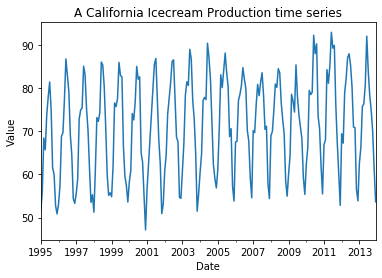

In [165]:
# Plot the Icecream Product data
df['Icecream.Prod'].plot()
plt.title('A California Icecream Production time series')
plt.ylabel('Value')
plt.xlabel('Date')

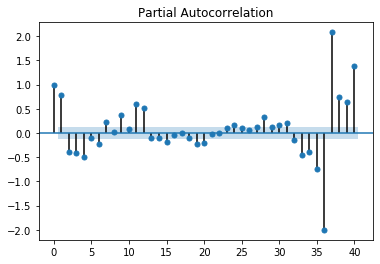

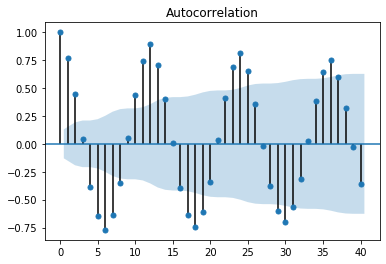

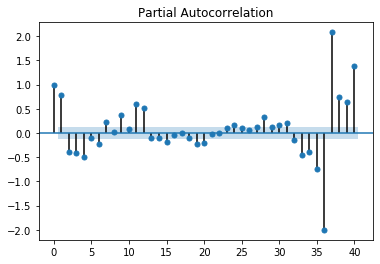

In [166]:
splt.plot_acf(df['Icecream.Prod'], lags = 40) # Plot the Autocorrelation
splt.plot_pacf(df['Icecream.Prod'], lags = 40) # Plot the Partial Autocorrelation

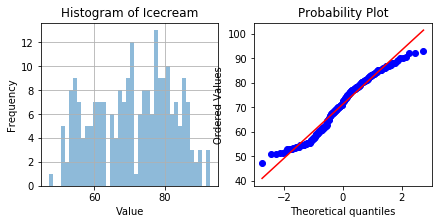

In [167]:
# Plot the distribution of Icecream Product data
dist_ts(df['Icecream.Prod'], 'Icecream')

***
#### Examine the results:
1. **From Autocorrelation Plot:** it has has continued periodicity.
2. **From Partial Autocorrelation Plot:** it has many significant values aside from 0.
3. **From the Histogram of Icecream & Q-Q-Plot:** both does show that this data does not have normal distribution.

Based from all those information, we can conclude that this icecream product time series is **non-stationary**.
***

# 2. Is there a significant seasonal component?

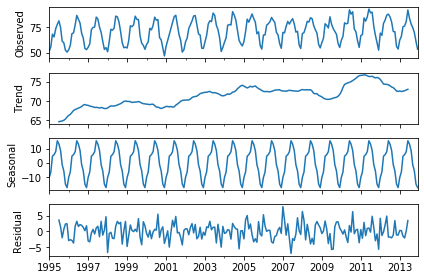

In [168]:
# Generate STL Decomposition model
decomp = decomp_ts(df['Icecream.Prod'])

***
#### Examine the results:
Based on the plots above, on the **Seasonal**, we do see the periodic pattern of this icecream product data. Therefore, there is a **significant seasonal component**.
***

# 3. For the residual from the STL decomposition of the time series what is the order of the ARMA(p,q) process that best fits?

In [169]:
# Compute p and q value for the best ARMA model from the STL decomposition model from above
BIC, order, model = step_ARIMA(decomp.resid[6:-6], 4, 0, 4)    
print('***************************************')
print('Best model with BIC = ' + str(BIC) + ' and with order '+ str(order))

Testing model of order: (0, 0, 1) with BIC = 1033.948397930495
Testing model of order: (0, 0, 2) with BIC = 1015.4096856995327
Testing model of order: (0, 0, 3) with BIC = 1034.858687921396
Testing model of order: (0, 0, 4) with BIC = 984.8590571118594
Testing model of order: (1, 0, 0) with BIC = 1034.1844707639357
Testing model of order: (1, 0, 1) with BIC = 1008.9611862654511
Testing model of order: (1, 0, 2) with BIC = 1001.0538950830589
Testing model of order: (1, 0, 3) with BIC = 1006.2497713727558
Testing model of order: (2, 0, 0) with BIC = 1038.491570599305
Testing model of order: (2, 0, 1) with BIC = 998.1642671288267
Testing model of order: (2, 0, 2) with BIC = 999.8422042595922
Testing model of order: (2, 0, 3) with BIC = 1003.9167155383927
Testing model of order: (3, 0, 0) with BIC = 1042.6228742699202
Testing model of order: (3, 0, 1) with BIC = 996.8789468581685
Testing model of order: (3, 0, 2) with BIC = 1001.4617859913453
Testing model of order: (3, 0, 3) with BIC = 98

In [170]:
# We founc the best order which is ARMA(4,1)
model_ARIMA(decomp.resid[6:-6], (4,0,1))

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                  216
Model:                     ARMA(4, 1)   Log Likelihood                -465.957
Method:                           mle   S.D. of innovations              2.069
Date:                Mon, 13 Jan 2020   AIC                            943.914
Time:                        23:02:39   BIC                            964.166
Sample:                    07-31-1995   HQIC                           952.096
                         - 06-30-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.resid     0.7519      0.063     11.984      0.000       0.629       0.875
ar.L2.resid    -0.1594      0.080     -1.982      0.049      -0.317      -0.002
ar.L3.resid     0.1596      0.080      1.989    

***
#### Examine the results:
From the above calculation, we found the best order of the ARMA model which is **(4,1)** where **p = 4** and **q = 1 **.
***

# 4. Then forecast production for 12 months and report both numeric values and plot the confidence intervals

In [171]:
## Create new features, the count of months from the start of the
## series and the square of the count of months
df.loc[:, 'Month_Cnt'] = [float(i + 1) for i in range(len(df['Icecream.Prod']))]
df.loc[:, 'Month_Cnt2'] = [x**2 for x in df.Month_Cnt]

## Normalize the time features
df.loc[:, ['Month_Cnt', 'Month_Cnt2']] = df.loc[:, ['Month_Cnt', 'Month_Cnt2']].apply(zscore)

## Create dummy variables for the months
dummies = pd.get_dummies(df.loc[:, 'Month'])
df[list(dummies.columns)] = dummies
## Print the head of the data frame to look at the dummy variables.
df.head(12) # look at the first year

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed,Month_Cnt,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
1995-01-31,1995,Jan,4.370,51.595,2.112,0.9803,1,1,1,-1.724471,...,0,0,1,0,0,0,0,0,0,0
1995-02-28,1995,Feb,3.695,56.086,1.932,0.8924,2,4,8,-1.709277,...,0,1,0,0,0,0,0,0,0,0
1995-03-31,1995,Mar,4.538,68.453,2.162,0.8924,3,9,27,-1.694084,...,0,0,0,0,0,1,0,0,0,0
1995-04-30,1995,Apr,4.280,65.722,2.130,0.8967,4,16,64,-1.678890,...,0,0,0,0,0,0,0,0,0,0
1995-05-31,1995,May,4.470,73.730,2.227,0.8967,5,25,125,-1.663696,...,0,0,0,0,0,0,1,0,0,0
1995-06-30,1995,Jun,4.238,77.994,2.124,0.9160,6,36,216,-1.648503,...,0,0,0,0,1,0,0,0,0,0
1995-07-31,1995,Jul,4.377,81.475,2.184,0.9160,7,49,343,-1.633309,...,0,0,0,1,0,0,0,0,0,0
1995-08-31,1995,Aug,4.368,74.981,2.152,0.8934,8,64,512,-1.618116,...,0,0,0,0,0,0,0,0,0,0
1995-09-30,1995,Sep,3.917,61.530,2.062,0.8934,9,81,729,-1.602922,...,0,0,0,0,0,0,0,0,0,1
1995-10-31,1995,Oct,4.078,60.022,2.121,0.9434,10,100,1000,-1.587729,...,0,0,0,0,0,0,0,0,1,0


In [172]:
df.tail(12) # look at the last year

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed,Month_Cnt,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
2013-01-31,2013,Jan,2.282,62.612,3.462,1.7744,217,47089,10218313,1.557341,...,0,0,1,0,0,0,0,0,0,0
2013-02-28,2013,Feb,1.941,66.274,3.231,1.6224,218,47524,10360232,1.572535,...,0,1,0,0,0,0,0,0,0,0
2013-03-31,2013,Mar,2.150,75.770,3.676,1.6968,219,47961,10503459,1.587729,...,0,0,0,0,0,1,0,0,0,0
2013-04-30,2013,Apr,2.217,76.396,3.622,1.7444,220,48400,10648000,1.602922,...,0,0,0,0,0,0,0,0,0,0
2013-05-31,2013,May,2.341,80.899,3.720,1.8552,221,48841,10793861,1.618116,...,0,0,0,0,0,0,1,0,0,0
2013-06-30,2013,Jun,2.694,92.091,3.489,1.8314,222,49284,10941048,1.633309,...,0,0,0,0,1,0,0,0,0,0
2013-07-31,2013,Jul,2.433,84.026,3.373,1.6923,223,49729,11089567,1.648503,...,0,0,0,1,0,0,0,0,0,0
2013-08-31,2013,Aug,2.169,78.382,3.400,1.6273,224,50176,11239424,1.663696,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2013,Sep,2.193,74.871,3.197,1.5519,225,50625,11390625,1.678890,...,0,0,0,0,0,0,0,0,0,1
2013-10-31,2013,Oct,2.284,70.011,3.338,1.5566,226,51076,11543176,1.694084,...,0,0,0,0,0,0,0,0,1,0


In [173]:
# Extract values for last 12 months used for forecasting
X = df.loc[:'2012-12-31', ['Month_Cnt', 'Month_Cnt2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].values
Y = df.loc[:'2012-12-31', 'Icecream.Prod'].values
lm_mod = lm.LinearRegression(fit_intercept = False)
mod_fit = lm_mod.fit(X, Y)
# Predictions and the residual
df.loc[:'2012-12-31', 'scores'] = mod_fit.predict(X)
df.loc[:'2012-12-31', 'resids'] = df.loc[:'2012-12-31', 'scores'] - df.loc[:'2012-12-31', 'Icecream.Prod']

In [174]:
# Compute the best ARIMA order
BIC, order, model_fit = step_ARIMA(df.loc[:'2012-12-31', 'resids'], 4, 3, 4)    
print('Best order = ' + str(order) + ' best BIC = ' + str(BIC))

Testing model of order: (0, 0, 1) with BIC = 1077.7895234312405
Testing model of order: (0, 0, 2) with BIC = 1082.5839455708121
Testing model of order: (0, 0, 3) with BIC = 1060.527672990147
Testing model of order: (0, 0, 4) with BIC = 1065.613847144987
Testing model of order: (0, 1, 1) with BIC = 1079.125763849743
Testing model of order: (0, 1, 3) with BIC = 1087.4255892356518
Testing model of order: (0, 2, 1) with BIC = 1169.5315527172963
Testing model of order: (1, 0, 0) with BIC = 1075.4541317025698
Testing model of order: (1, 0, 1) with BIC = 1074.7202626876535
Testing model of order: (1, 0, 2) with BIC = 1079.3882909928798
Testing model of order: (1, 0, 3) with BIC = 1065.482569198243
Testing model of order: (1, 1, 0) with BIC = 1120.8044126058796
Testing model of order: (1, 1, 1) with BIC = 1081.901419618533
Testing model of order: (1, 1, 2) with BIC = 1077.165442616407
Testing model of order: (1, 1, 3) with BIC = 1082.5049769638074
Testing model of order: (1, 1, 4) with BIC = 1

In [175]:
# The best ARIMA order is (0,0,3)
arima_remainder = model_ARIMA(df.loc[:'2012-12-31', 'resids'], order = (0,0,3))

                              ARMA Model Results                              
Dep. Variable:                 resids   No. Observations:                  216
Model:                     ARMA(0, 3)   Log Likelihood                -519.513
Method:                           mle   S.D. of innovations              2.678
Date:                Mon, 13 Jan 2020   AIC                           1047.027
Time:                        23:03:05   BIC                           1060.528
Sample:                    01-31-1995   HQIC                          1052.481
                         - 12-31-2012                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ma.L1.resids     0.2807      0.065      4.318      0.000       0.153       0.408
ma.L2.resids     0.0896      0.067      1.330      0.185      -0.042       0.222
ma.L3.resids     0.3649      0.062      5.87

In [176]:
# Predictions from the order model
start_index = len(df.loc[:'2012-12-31', 'resids']) - 1
end_index = start_index + 12
# model prediction
model_prediction = arima_remainder.predict(start=start_index, end=end_index)
model_prediction

2012-12-31    0.186891
2013-01-31   -0.023234
2013-02-28    1.088693
2013-03-31    1.060365
2013-04-30    0.000000
2013-05-31    0.000000
2013-06-30    0.000000
2013-07-31    0.000000
2013-08-31    0.000000
2013-09-30    0.000000
2013-10-31    0.000000
2013-11-30    0.000000
2013-12-31    0.000000
Freq: M, dtype: float64

In [177]:
# Make the forecast for the next year
X = df.loc['2012-12-31':, ['Month_Cnt', 'Month_Cnt2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].values # .as_matrix() obsolete
# and the predictions for the forecast
df.loc['2012-12-31':, 'scores'] =  mod_fit.predict(X) - model_prediction

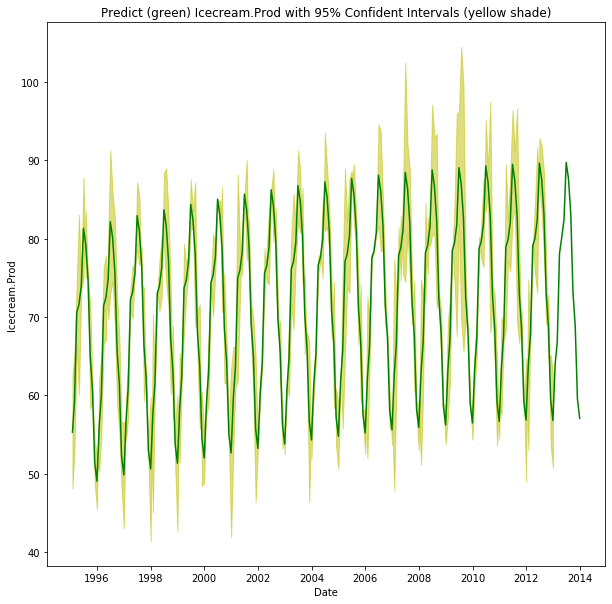

In [178]:
# Plot predict value with 95% Confident Intervals
plot_forecast(df, 'Icecream.Prod')

## - 4.1 Are the confidence intervals reasonably small compared to the forecast means?

Based on the plot above, the **95% confidence intervals** has pretty small band compared to the forecase means (scores).

## - 4.2 How do the confidence intervals behave as time moves to the future?

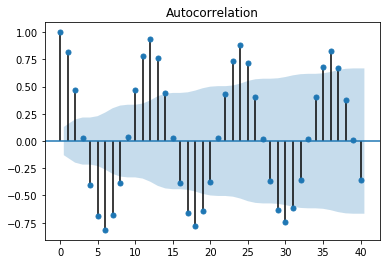

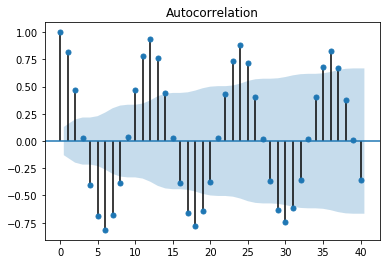

In [180]:
# Plot the autocorrelation of the forcast means
splt.plot_acf(df['scores'], lags = 40)

Based on the plot above, the **95% confidence intervals** moving as a seasonal pattern.